<a href="https://colab.research.google.com/github/batiukmaks/Computer-Vision-Labs/blob/main/Lab2_and_RANSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
BASE_DIR = "drive/MyDrive/Term 8/CV/Lab2"

# SIFT

In [ ]:
def compute_descriptors(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create(contrastThreshold=0.1)
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    return descriptors, keypoints

def euclidean_distance(desc1, desc2):
    return np.linalg.norm(desc1 - desc2)

def match_keypoints(des1, des2, matches_filter_mode="asc"):
    matches = []

    # Проходимо по кожному дескриптору з першого зображення
    for i, desc1 in enumerate(des1):
        best_match = None
        best_distance = float('inf')

        # Знаходимо найближчі дескриптори на другому зображенні
        for j, desc2 in enumerate(des2):
            dist = euclidean_distance(desc1, desc2)
            if dist < best_distance:
                best_distance = dist
                best_match = (i, j, dist)

        if best_match:
            matches.append(best_match)

    if matches_filter_mode == "asc":
        matches.sort(key=lambda x: x[2])
    elif matches_filter_mode == "desc":
        matches.sort(key=lambda x: x[2], reverse=True)

    return matches

In [ ]:
def compute_homography(pts1, pts2):
    """
    Обчислює гомографію між двома наборами точок.

    :param pts1: Массив точок на першому зображенні (Nx2)
    :param pts2: Массив точок на другому зображенні (Nx2)
    :return: матриця гомографії 3x3
    """
    # Створюємо матрицю A для вирішення системи рівнянь
    A = []
    for (x1, y1), (x2, y2) in zip(pts1, pts2):
        A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])

    # Перетворюємо A в numpy масив
    A = np.array(A)

    # Використовуємо SVD для знаходження власних значень
    _, _, V = np.linalg.svd(A)

    # Гомографія знаходиться в останньому ряді V
    H = V[-1].reshape(3, 3)

    # Нормалізуємо матрицю H (робимо останній елемент рівним 1)
    H = H / H[2, 2]

    return H

def ransac(matches, keypoints1, keypoints2, threshold=5, iterations=1000):
    best_inliers = []
    best_homography = None

    for _ in range(iterations):
        # Вибираємо 4 випадкові пари точок (індекси)
        sample = random.sample(matches, 4)

        # Визначаємо пари точок для обчислення гомографії
        pts1 = np.array([keypoints1[i].pt for i, _, _ in sample])
        pts2 = np.array([keypoints2[j].pt for _, j, _ in sample])

        # Обчислюємо гомографію між точками
        # homography, _ = cv2.findHomography(pts1, pts2, method=0)
        homography = compute_homography(pts1, pts2)

        # Перевіряємо, скільки точок узгоджуються з гомографією
        inliers = []
        for i, (i1, j2, _) in enumerate(matches):
            pt1 = np.array([keypoints1[i1].pt[0], keypoints1[i1].pt[1], 1])
            pt2 = np.array([keypoints2[j2].pt[0], keypoints2[j2].pt[1], 1])

            projected_pt2 = np.dot(homography, pt1)
            projected_pt2 /= projected_pt2[2]  # Нормалізація

            distance = np.linalg.norm(projected_pt2[:2] - pt2[:2])
            if distance < threshold:
                inliers.append((i1, j2, distance))

        # Зберігаємо найкращу гомографію, якщо вона має більше inliers
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_homography = homography

    return best_inliers, best_homography


In [ ]:
def find_matches(img1, img2, use_ransac=False, matches_filter_mode="asc"):
    # Обчислюємо ключові точки і дескриптори
    des1, kp1 = compute_descriptors(img1)
    des2, kp2 = compute_descriptors(img2)

    # Знаходимо матчі між зображеннями
    matches = match_keypoints(des1, des2, matches_filter_mode=matches_filter_mode)

    if use_ransac:
        # Застосовуємо RANSAC для фільтрації хибних матчів
        inliers, homography = ransac(matches, kp1, kp2)
        return inliers, kp1, kp2, des1, des2
    else:
        return matches, kp1, kp2, des1, des2

In [ ]:
def show_matches(img1, img2, kp1, kp2, matches, use_ransac=False, title='Відповідності між зображеннями'):
    # Якщо RANSAC не використовується, малюємо всі матчі
    match_img = cv2.hconcat([img1, img2])
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Малюємо лінії для кожного з першої частини матчів
    for i, j, _ in matches[:30]:  # Обмежуємо кількість ліній до 30
        pt1 = tuple(map(int, kp1[i].pt))
        pt2 = tuple(map(int, kp2[j].pt))
        pt2 = (pt2[0] + w1, pt2[1])
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.line(match_img, pt1, pt2, color, 2)

    # Показуємо зображення з відповідностями за допомогою matplotlib
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title)
    plt.show()

def rotate_image(image, angle):
    # Отримуємо розміри зображення
    h, w = image.shape[:2]

    # Обчислюємо матрицю трансформації для повороту
    center = (w // 2, h // 2)  # Центр зображення
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)  # Матричний перерахунок

    # Повертаємо зображення за допомогою матриці трансформації
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))

    return rotated_image

def run_sift(image_path, use_ransac=False, matches_filter_mode="asc", title='Відповідності між зображеннями'):
    img1 = cv2.imread(image_path)
    img2 = rotate_image(img1, -30)

    matches, kp1, kp2, des1, des2 = find_matches(
        img1,
        img2,
        use_ransac=use_ransac,
        matches_filter_mode=matches_filter_mode
    )

    show_matches(img1, img2, kp1, kp2, matches, use_ransac=use_ransac, title=title)


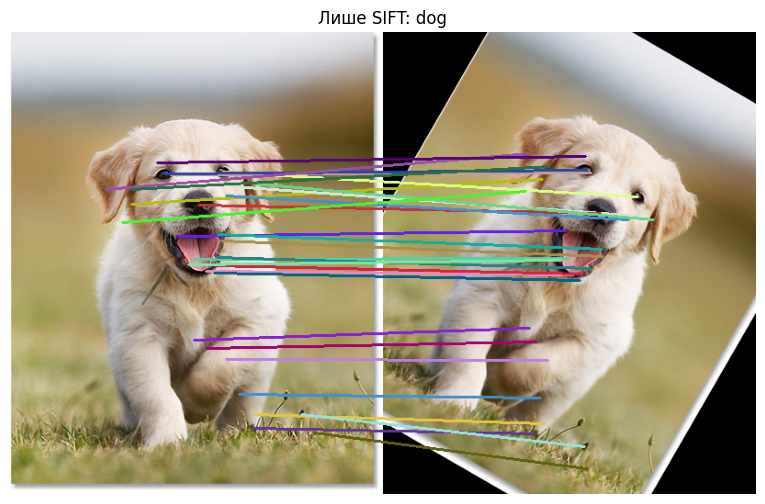

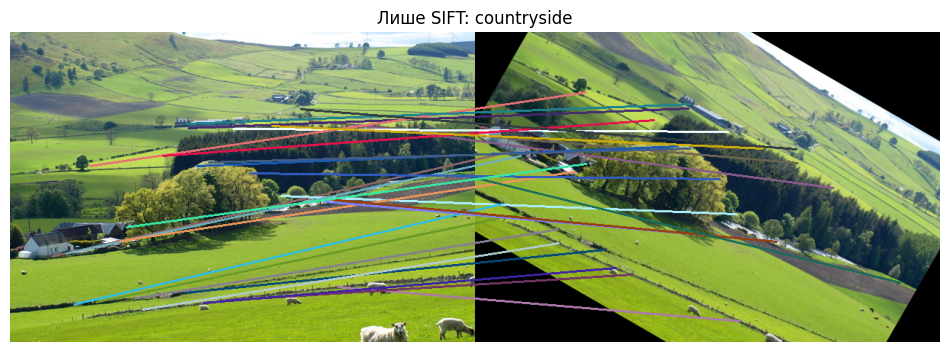

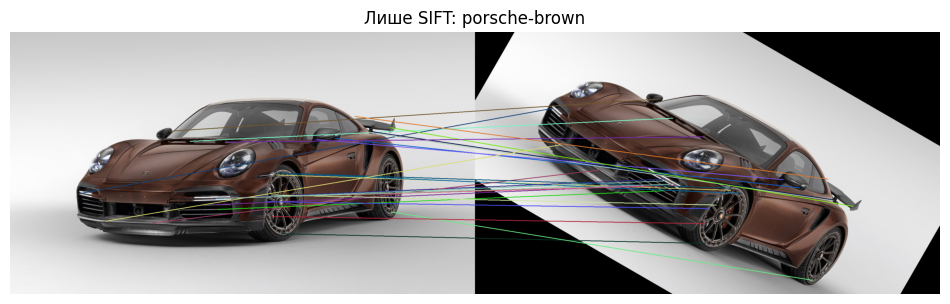

In [ ]:
for filename in [
    "dog.jpg",
    "countryside.jpg",
    "porsche-brown.jpg",
]:
    run_sift(
        image_path=os.path.join(BASE_DIR, "photos", filename),
        title=f"Лише SIFT: {filename.split('.')[0]}"
    )

# RANCAS

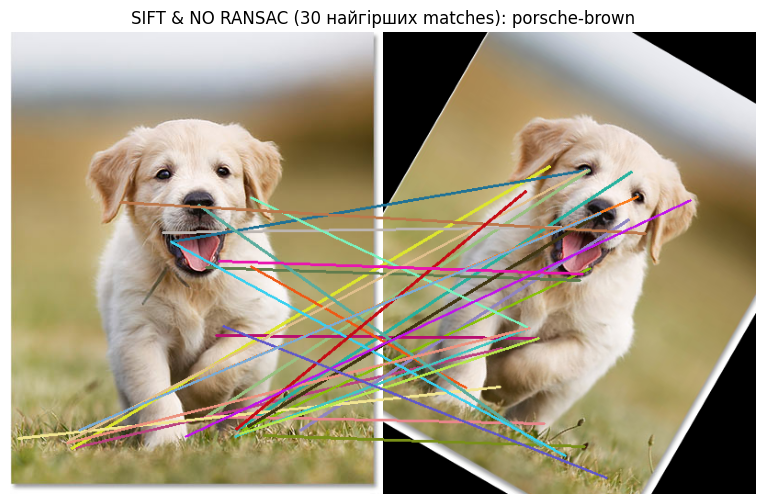

In [ ]:
run_sift(
    image_path=os.path.join(BASE_DIR, "photos", "dog.jpg"),
    use_ransac=False,
    matches_filter_mode="desc",
    title=f"SIFT & NO RANSAC (30 найгірших matches): {filename.split('.')[0]}"
)

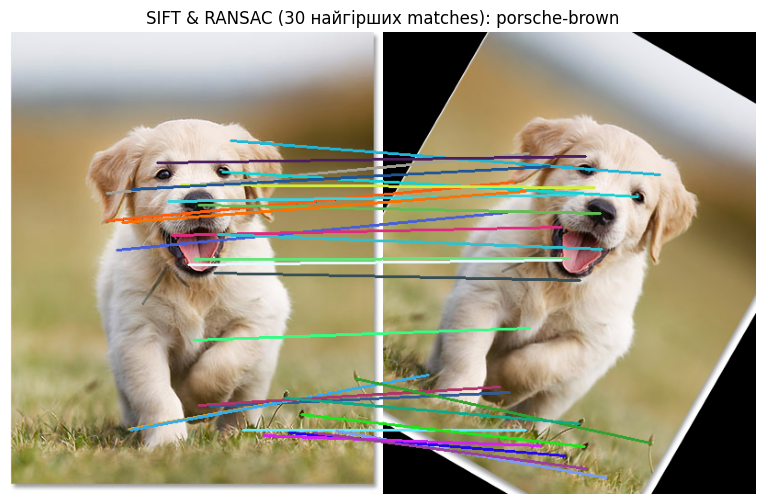

In [ ]:
run_sift(
    image_path=os.path.join(BASE_DIR, "photos", "dog.jpg"),
    use_ransac=True,
    matches_filter_mode="desc",
    title=f"SIFT & RANSAC (30 найгірших matches): {filename.split('.')[0]}"
)